## **Notebook #7**
## Autoencoder training and manifold visualization for the MNIST database.
## Partially based on [this material](https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders).
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Arthur Felipe dos Santos Fernandes

### Loading the main libraries

In [1]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

### Reading the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [5]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

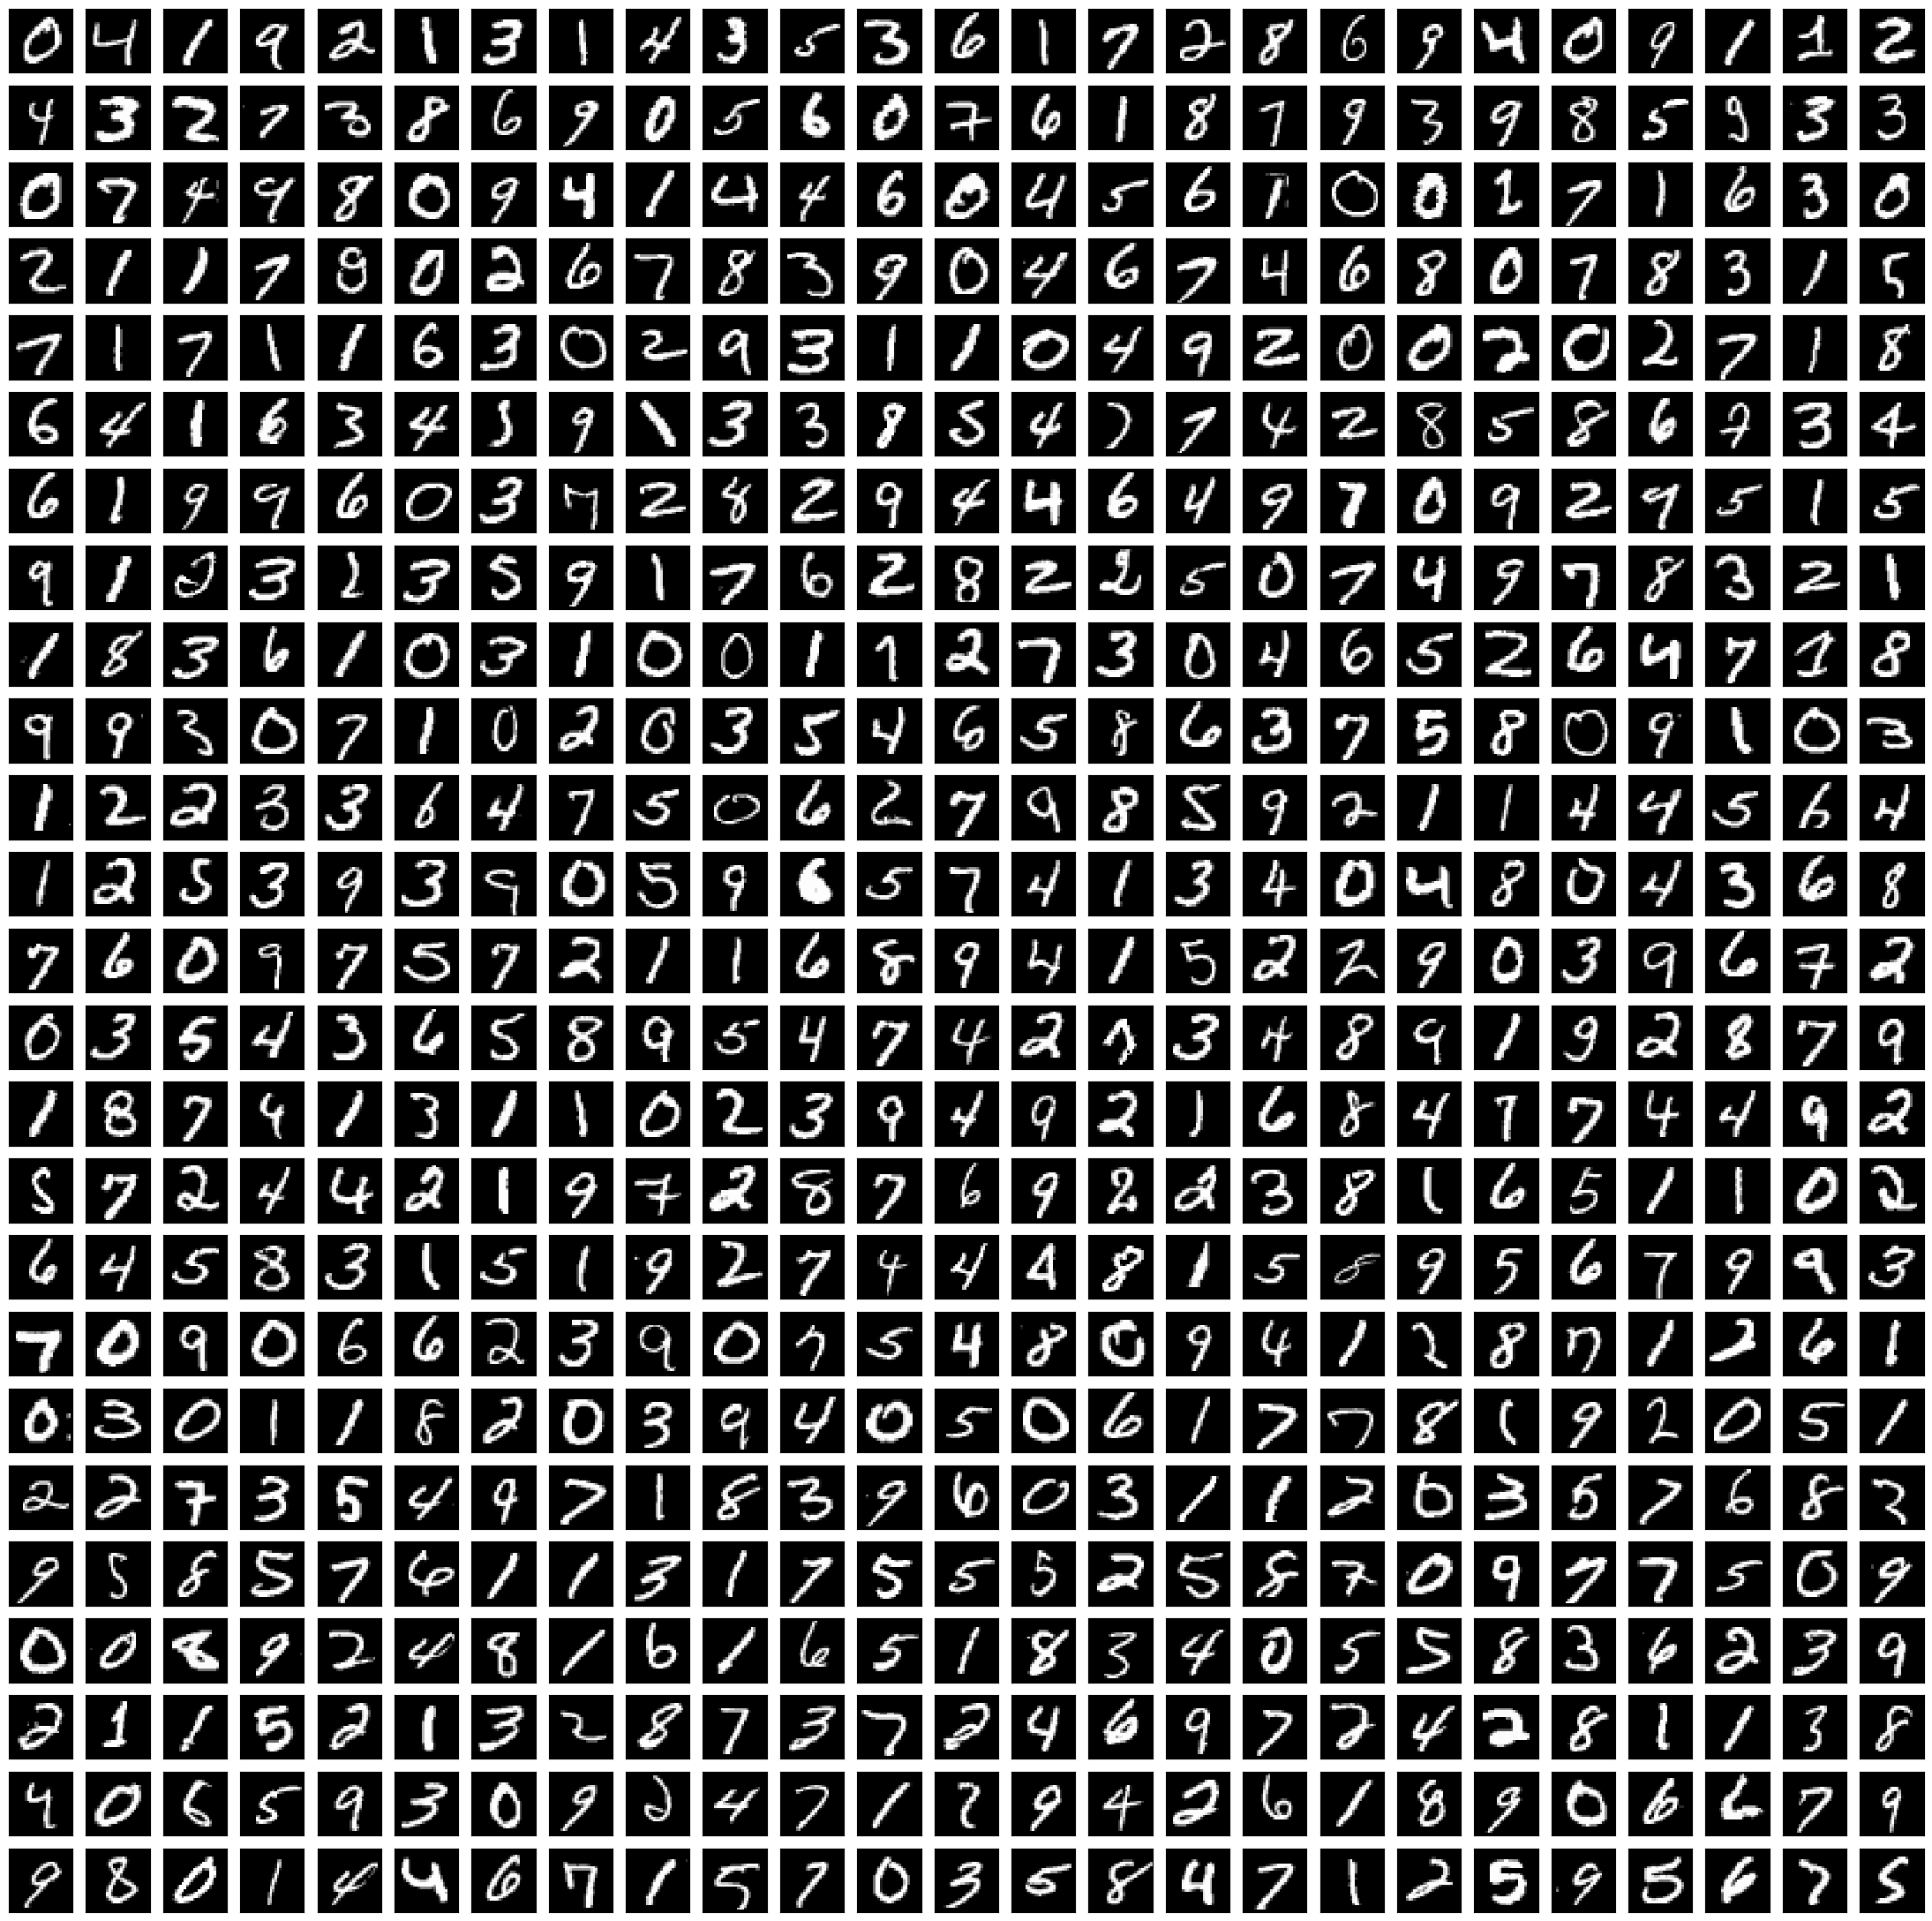

In [6]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### Proposal for the autoencoder architecture

In [32]:
import keras.layers as layers

input_img = Input(shape=(28, 28, 1))

encoded = layers.Conv2D(10, 28, activation='relu', padding= 'same')(input_img)
encoded = layers.BatchNormalization()(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = layers.Conv2D(10, 28, activation='relu', padding= 'same')(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded)
encoded = layers.Conv2D(10, 28, activation='relu', padding= 'same')(encoded)
encoded = layers.BatchNormalization()(encoded)

encoded = Dense(2)(encoded)

decoded = layers.Conv2D(10, 28, activation='relu', padding= 'same')(encoded)
decoded = layers.UpSampling2D((2,2))(decoded)
decoded = layers.Conv2D(10, 28, activation='relu', padding= 'same')(decoded)
decoded = layers.UpSampling2D((2,2))(decoded)
decoded = layers.Conv2D(1, 28, activation='sigmoid', padding= 'same')(decoded)

autoencoder = Model(input_img, decoded)
print(decoded.shape)

(None, 28, 28, 1)


In [19]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 10)        50        
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 10)       40        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 10)        410       
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 10)       40  

In [33]:
autoencoder.compile(optimizer = "adam", loss = "mse")
X = x_train.reshape(x_train.shape[0], 28, 28, 1)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 10, verbose = 1)

Epoch 1/10
469/469 [==============================] - 21s 35ms/step - loss: 0.0309
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 0.0093
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 0.0071
Epoch 4/10
469/469 [==============================] - 15s 33ms/step - loss: 0.0060
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0054
Epoch 6/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0051
Epoch 7/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0048
Epoch 8/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0045
Epoch 9/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0043
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0040


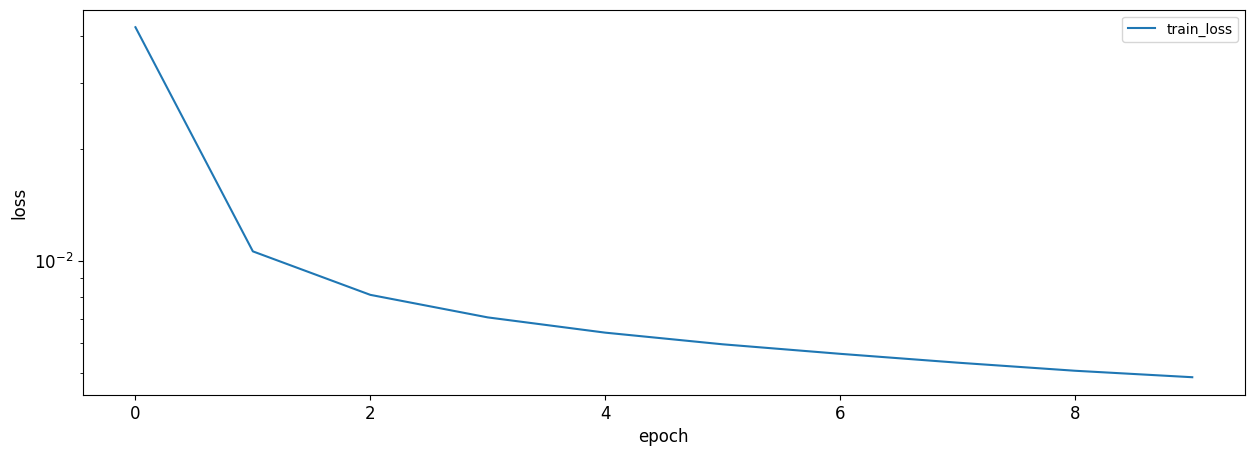

In [29]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

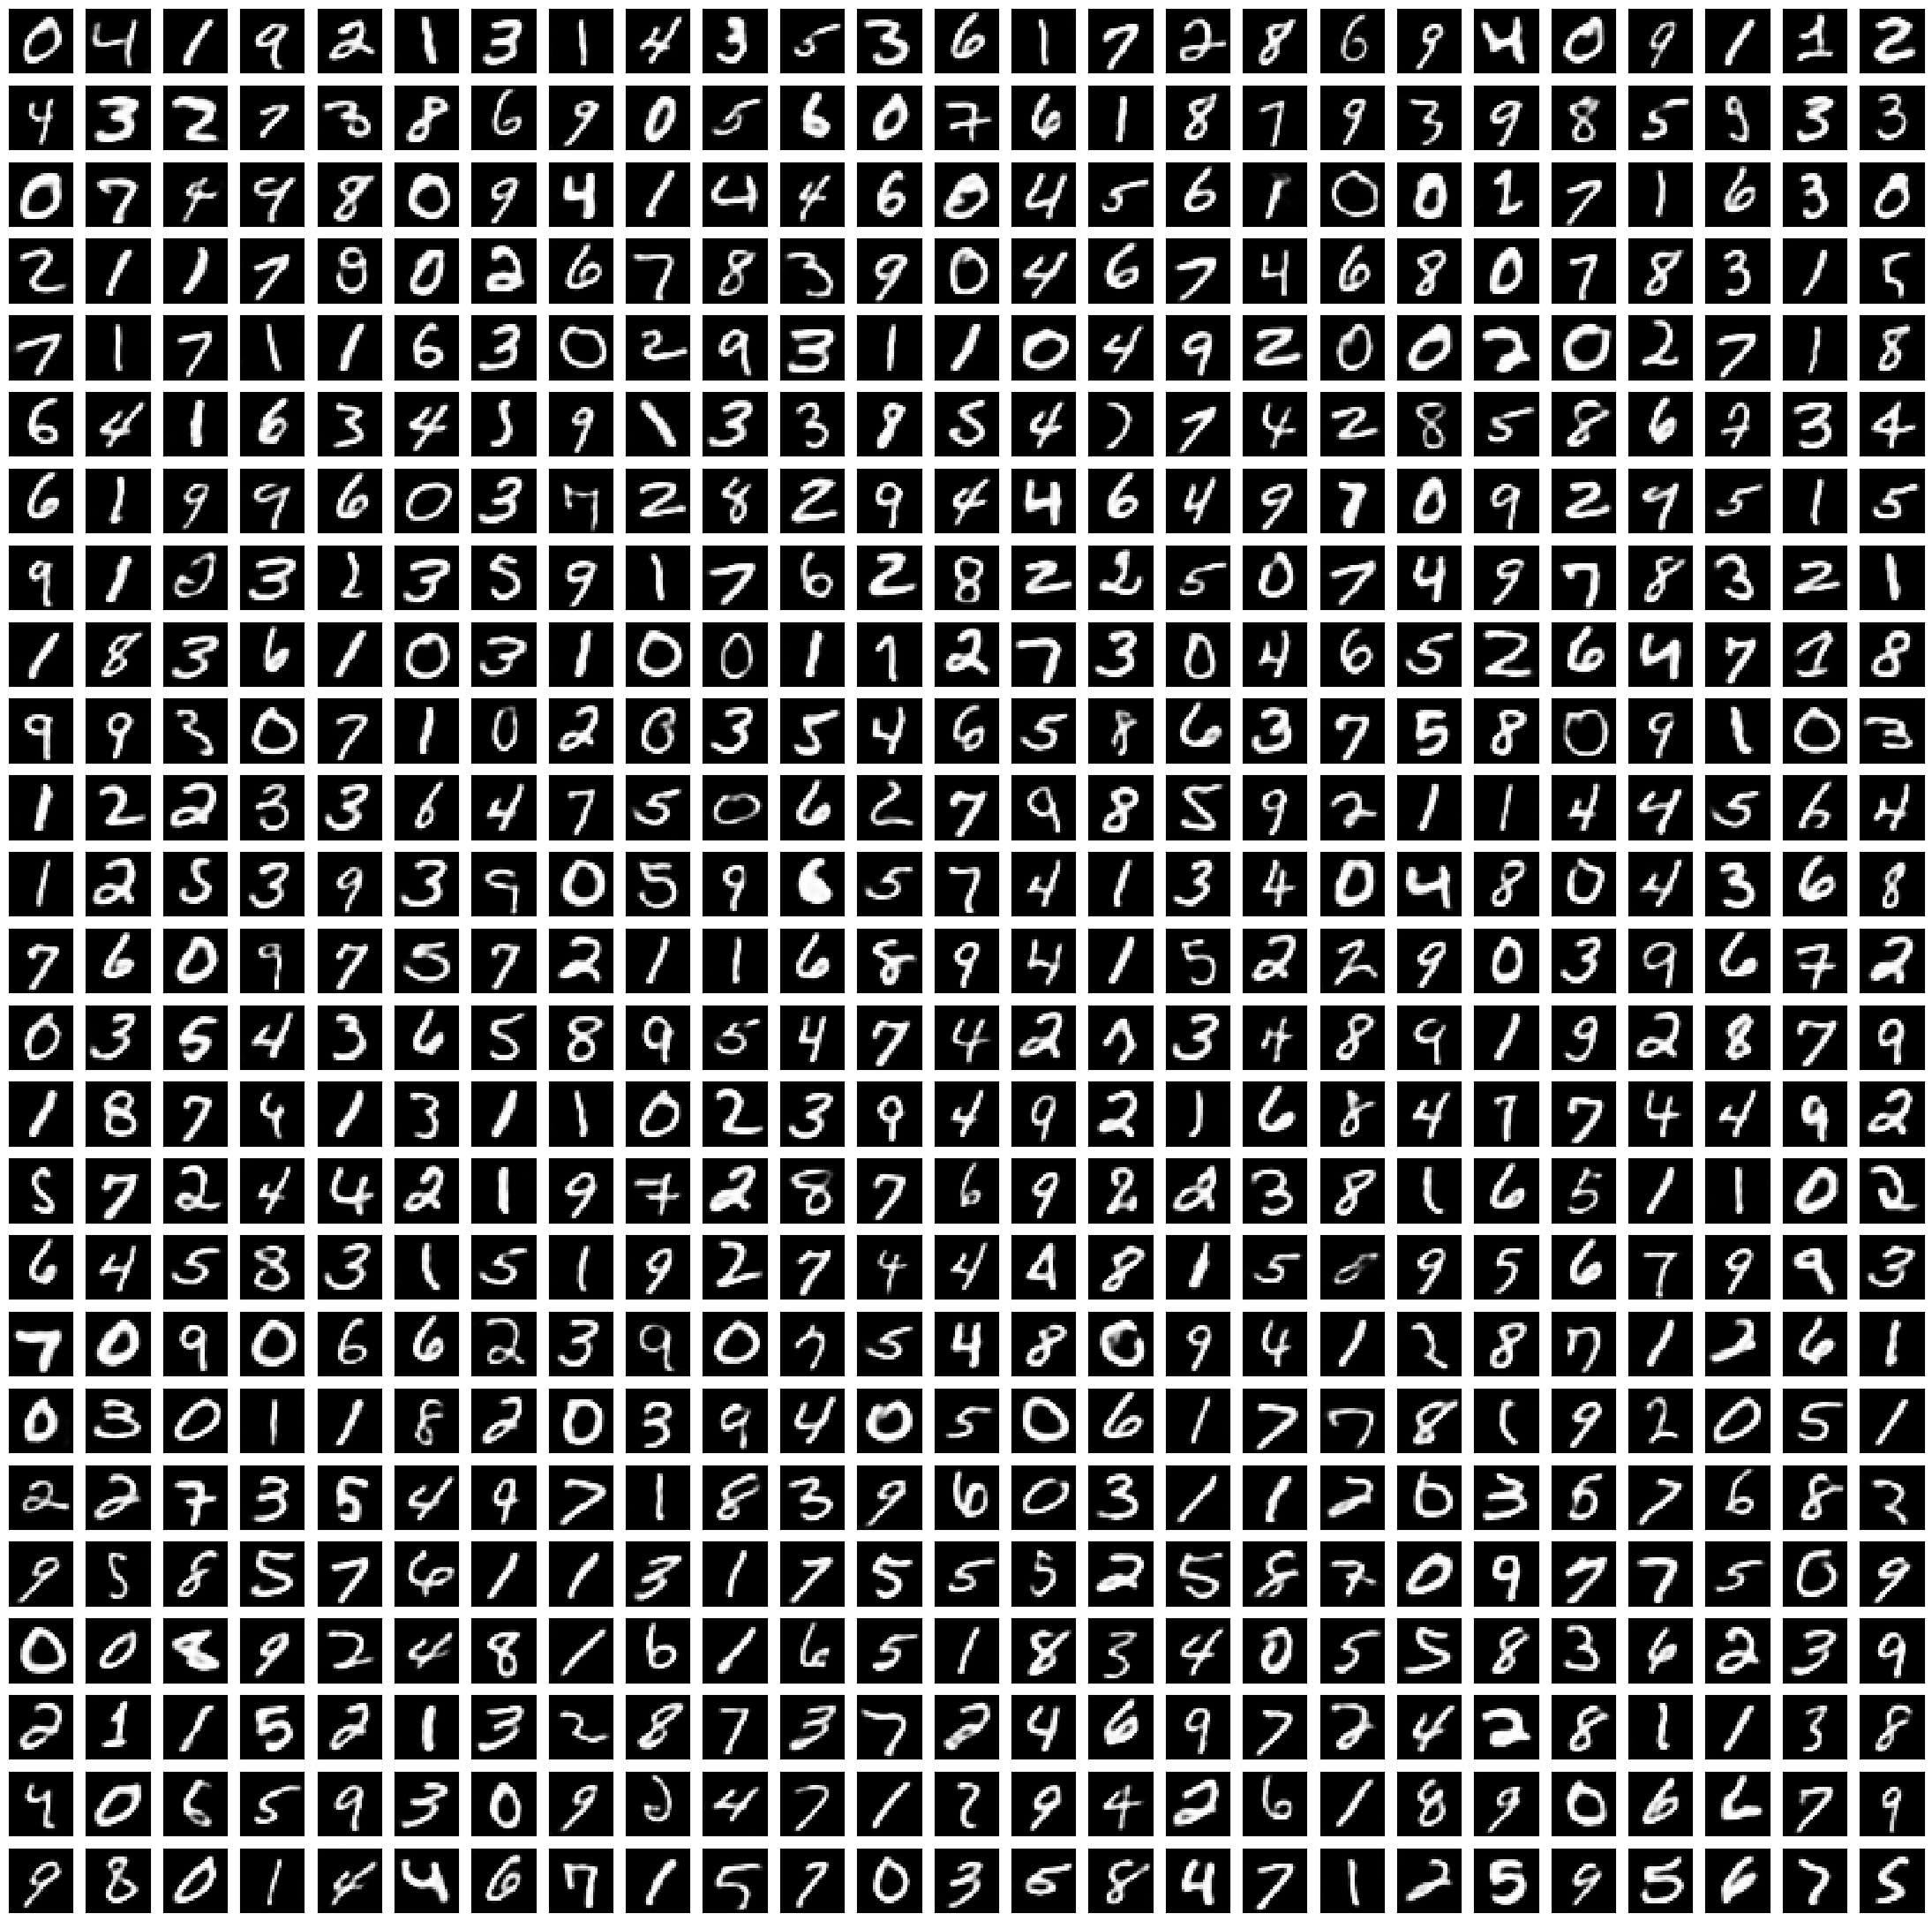

In [34]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        image = np.expand_dims(x_images[ind], axis=0)  # Adicionar dimensão de lote
        image = np.expand_dims(image, axis=-1)  # Adicionar dimensão de canal de cores
        show(autoencoder.predict(image, verbose = 0)[0].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [ ]:
encoder = Model(input_img, encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-4]
encoded_layer_2 = autoencoder.layers[-3]
encoded_layer_3 = autoencoder.layers[-2]
encoded_layer_4 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = Model(encoded_input, decoder)

### Visualizing the images in the manifold

In [ ]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot(x="comp_1",y= "comp_2", hue="labels", data=proj, fit_reg=False)

### Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### Moving along a circle

In [ ]:
_ = sns.lmplot(x ="comp_1",y= "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [4 * np.cos(2 * np.pi / 100 * i) - 2 for i in range(100)]
all_y = [4 * np.sin(2 * np.pi / 100 * i) + 1 for i in range(100)]
_ = plt.plot(all_x,all_y, color = 'black')

In [ ]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 4 * np.cos(2 * np.pi / 100 * i) - 2
    y = 4 * np.sin(2 * np.pi / 100 * i) + 1
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along an ellipse

In [ ]:
_ = sns.lmplot(x="comp_1", y="comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [5 * np.cos(2 * np.pi / 100 * i) - 2 for i in range(100)]
all_y = [1 * np.sin(2 * np.pi / 100 * i) + 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

In [ ]:
# Moving along an elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 5 * np.cos(2 * np.pi / 100 * i) - 2
    y = 1 * np.sin(2 * np.pi / 100 * i) + 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along a grid

In [ ]:
# Moving along a grid:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])